# Target Trial Emulation (TTE)

Target Trial Emulation (TTE) is a methodological framework designed to estimate causal treatment effects from observational data while minimizing biases inherent in traditional designs (Hernán & Robins, 2016). The TTE approach typically involves creating a pseudo-randomized trial structure—expanding observational data into multiple “trials” and adjusting for key time-dependent confounders and censoring processes through inverse probability weighting (Robins et al., 2000). However, real-world datasets often contain heterogeneous subgroups of patients with different baseline risks or censoring mechanisms. To address this heterogeneity, we introduce a clustering step via Gaussian Mixture Models (GMM), which can capture more flexible (potentially overlapping or non-spherical) clusters than K-Means (McLachlan & Peel, 2000).

## Why GMM?

Unlike K-Means, which partitions patients into spherical clusters centered on means, GMM assigns probabilities of belonging to each cluster and estimates each subgroup through a distinct multivariate Gaussian distribution. This approach can capture more complex patterns in variables such as age, comorbidities (x1, x2), or other risk factors. By incorporating these probabilities as discrete cluster assignments, the analysis can stratify both censoring weights and outcome models according to more nuanced patient subpopulations.

## Cluster Integration in Weights and MSM

After assigning cluster labels to each patient, we include the cluster variable in both the numerator and denominator of the inverse probability of censoring weights (IPCW). This allows each subgroup to have distinct censoring mechanisms. In the final Marginal Structural Model (MSM), we again include cluster as a categorical covariate, thereby enabling estimation of different baseline risks or, if desired, effect modification by cluster (e.g., “treatment*C(cluster)”). This two-step integration ensures that potential differences in censoring and outcome risk across subpopulations are explicitly accounted for in the causal analysis.

## Trial Expansion

The code demonstrates a simplified logic of repeating each row from `followup_time=0` up to the observed period. In practice, TTE expansions often stop at censoring or event occurrence, or incorporate time-varying eligibility conditions. Aligning expansions with the real-time at risk is crucial to avoid immortal time bias and other pitfalls (Hernán & Robins, 2016). Users looking to emulate a specific trial design can refine the expansion logic to match the corresponding enrollment and follow-up structures they aim to replicate.

## Visualizing Multiple Clusters

To illustrate heterogeneous treatment effects or censoring mechanisms, we display survival curves stratified by both treatment and cluster. As cluster membership often reflects clinically or biologically meaningful subgroups, these visualizations help detect whether certain subpopulations experience greater mortality or different treatment benefits. Users can further facet by cluster, apply color coding, or produce interactive plots with Plotly to better convey these differences (Hastie et al., 2009).

## Modeling Diagnostics for GLMs

Because the final MSM is typically a logistic regression, we employ diagnostic plots such as Q-Q plots, residual plots, and Cook’s distance to evaluate potential outliers, high-leverage points, or model misfit. This step is approximate in logistic regression and should be complemented by domain-specific knowledge and sensitivity checks (McCullagh & Nelder, 1989). When extreme weights appear or deviance residuals exhibit strong systematic patterns, analysts may consider trimming or stabilizing the weights, or refining the covariate selection in both the censoring and outcome models.

Overall, by combining GMM-based clustering with traditional TTE steps—weight calculation, trial expansion, and marginal structural outcome modeling—analysts can more rigorously account for patient heterogeneity in complex observational studies. This pipeline preserves the key advantages of TTE (e.g., addressing time-varying confounding and censoring) while enhancing the framework to capture and visualize subgroup differences more flexibly.

---



# Imports and Data Loading

In [2]:
import numpy as np
import pandas as pd

# Modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial

# For clustering (GMM)
from sklearn.mixture import GaussianMixture

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Interactive plots
import plotly.express as px
import plotly.graph_objs as go

# Diagnostics
from statsmodels.stats.outliers_influence import OLSInfluence

data = pd.read_csv("../data/data_censored.csv")

# Columns: id, period, treatment, x1, x2, x3, x4, age, age_s, outcome, censored, eligible
print(f"Data loaded. Shape: {data.shape}")
data.head(5)

Data loaded. Shape: (725, 12)


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


# Core Functionality - Trial Sequence Setup, Minimal Metadata for the trial

In [3]:
trial_settings = {
    'estimand': 'PP', # Could be 'PP' or 'ITT'
    'id_col': 'id',
    'period_col': 'period',
    'treatment_col': 'treatment',
    'outcome_col': 'outcome',
    'eligible_col': 'eligible',
    'censored_col': 'censored'
}

print("Trial estimand:", trial_settings['estimand'])
print(data.describe(include='all'))

n_patients = data[trial_settings['id_col']].nunique()
print(f"Number of unique subjects: {n_patients}")


Trial estimand: PP
               id      period   treatment          x1          x2          x3  \
count  725.000000  725.000000  725.000000  725.000000  725.000000  725.000000   
mean    49.278621    7.051034    0.467586    0.405517   -0.173552    0.486897   
std     28.119313    5.802351    0.499293    0.491331    0.997552    0.500173   
min      1.000000    0.000000    0.000000    0.000000   -3.284355    0.000000   
25%     23.000000    2.000000    0.000000    0.000000   -0.809344    0.000000   
50%     50.000000    6.000000    0.000000    0.000000   -0.163060    0.000000   
75%     73.000000   12.000000    1.000000    1.000000    0.494103    1.000000   
max     99.000000   19.000000    1.000000    1.000000    3.907648    1.000000   

               x4         age       age_s     outcome   censored    eligible  
count  725.000000  725.000000  725.000000  725.000000  725.00000  725.000000  
mean    -0.274722   48.093793    1.091149    0.015172    0.08000    0.234483  
std      1.008

# Clustering with Gaussian Mixture Modeling (GMM)

We cluster patients based on some baseline characteristics:

e.g., mean x1, x2, age across each patient.

In [4]:
patient_level = data.groupby('id').agg({
    'x1':'mean',
    'x2':'mean',
    'age':'mean'
}).reset_index()

Use GaussianMixture to learn a mixture of 3 Gaussians (as a demonstration).

In [5]:
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(patient_level[['x1','x2','age']].values)

GaussianMixture(n_components=3, random_state=42)

# Predict cluster memberships

In [6]:
patient_level['cluster'] = gmm.predict(patient_level[['x1','x2','age']])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(


# Merge cluster labels back into original data

In [7]:
data = data.merge(patient_level[['id','cluster']], on='id', how='left')

print("GMM means (component means in x1, x2, age space):\n", gmm.means_)
print("\nGMM covariances (component covariance matrices):\n", gmm.covariances_)

data.head(5)

GMM means (component means in x1, x2, age space):
 [[ 3.67940372e-01  4.22639288e-01  3.99590243e+01]
 [ 4.14866950e-01 -1.84535138e-01  4.86810642e+01]
 [ 2.44675920e-01  4.09376723e-02  2.55010526e+01]]

GMM covariances (component covariance matrices):
 [[[ 1.52170773e-01  3.05713285e-02 -7.49286877e-01]
  [ 3.05713285e-02  9.53090529e-01  1.90880656e+00]
  [-7.49286877e-01  1.90880656e+00  1.76238694e+01]]

 [[ 2.25785565e-02  1.11006753e-02 -1.89201304e-02]
  [ 1.11006753e-02  9.14336244e-02  7.51807554e-02]
  [-1.89201304e-02  7.51807554e-02  9.74770745e+01]]

 [[ 1.38486950e-01  6.12389551e-02  1.01230785e-01]
  [ 6.12389551e-02  6.05567938e-01 -2.59258429e-01]
  [ 1.01230785e-01 -2.59258429e-01  1.18633564e+01]]]


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,cluster
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0,1
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0,1
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0,1
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0,1


# Weight Calculation (Incorporating GMM Clusters)

We define not_censored = 1 - censored, then fit numerator & denominator

logistic models that include 'cluster' as a categorical variable.

In [8]:
data['not_censored'] = 1 - data[trial_settings['censored_col']]

numerator model: not_censored ~ x2 + C(cluster)

In [9]:
num_formula = "not_censored ~ x2 + C(cluster)"

denominator model: not_censored ~ x2 + x1 + C(cluster)

In [10]:
den_formula = "not_censored ~ x2 + x1 + C(cluster)"

model_num = smf.glm(formula=num_formula, data=data, family=Binomial()).fit()
model_den = smf.glm(formula=den_formula, data=data, family=Binomial()).fit()

data['p_num'] = model_num.predict(data)
data['p_den'] = model_den.predict(data)
data['ipw'] = data['p_num'] / data['p_den']

print("Numerator model summary:")
print(model_num.summary())
print("\nDenominator model summary:")
print(model_den.summary())

Numerator model summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:           not_censored   No. Observations:                  725
Model:                            GLM   Df Residuals:                      721
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -149.30
Date:                Sun, 09 Mar 2025   Deviance:                       298.60
Time:                        19:36:34   Pearson chi2:                     753.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1356
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        

# Basic distribution check of IPW

In [11]:
data['ipw'].describe()

count    725.000000
mean       1.000921
std        0.032394
min        0.837374
25%        0.992775
50%        1.003393
75%        1.006720
max        1.107548
Name: ipw, dtype: float64

# Trial Expansion

In [12]:
def expand_trials(input_df, id_col='id', period_col='period'):
    expanded_rows = []
    for pid, subdf in input_df.groupby(id_col):
        for idx, row_data in subdf.iterrows():
            max_period = int(row_data[period_col])
            for t in range(max_period+1):
                new_row = row_data.copy()
                new_row['followup_time'] = t
                expanded_rows.append(new_row)
                expanded_df = pd.DataFrame(expanded_rows).reset_index(drop=True)
    return expanded_df

expanded_data = expand_trials(data,
trial_settings['id_col'],
trial_settings['period_col'])

print("Original data shape:", data.shape)
print("Expanded data shape:", expanded_data.shape)
expanded_data.head()

Original data shape: (725, 17)
Expanded data shape: (5837, 18)


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,cluster,not_censored,p_num,p_den,ipw,followup_time
0,1.0,0.0,1.0,1.0,1.146148,0.0,0.734203,36.0,0.083333,0.0,0.0,1.0,1.0,1.0,0.954502,0.965650,0.988455,0.0
1,1.0,1.0,1.0,1.0,0.002200,0.0,0.734203,37.0,0.166667,0.0,0.0,0.0,1.0,1.0,0.970518,0.978349,0.991995,0.0
2,1.0,1.0,1.0,1.0,0.002200,0.0,0.734203,37.0,0.166667,0.0,0.0,0.0,1.0,1.0,0.970518,0.978349,0.991995,1.0
3,1.0,2.0,1.0,0.0,-0.481762,0.0,0.734203,38.0,0.250000,0.0,0.0,0.0,1.0,1.0,0.975509,0.970919,1.004726,0.0
4,1.0,2.0,1.0,0.0,-0.481762,0.0,0.734203,38.0,0.250000,0.0,0.0,0.0,1.0,1.0,0.975509,0.970919,1.004726,1.0


# Outcome Modeling (MSM)

Merge IPW into the expanded dataset based on (id, period).

In [13]:
expanded_merged = pd.merge(
    expanded_data,
    data[['id','period','ipw']],
    on=['id','period'],
    how='left',
    suffixes=('', '_orig')
)

In [14]:
msm_formula = "outcome ~ treatment + followup_time + I(followup_time**2) + C(cluster)"

msm_model = smf.glm(formula=msm_formula,
data=expanded_merged,
family=Binomial(),
freq_weights=expanded_merged['ipw']).fit()

print("MSM Model Summary with GMM clusters:")
print(msm_model.summary())

MSM Model Summary with GMM clusters:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 5837
Model:                            GLM   Df Residuals:                  5832.84
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -404.20
Date:                Sun, 09 Mar 2025   Deviance:                       808.41
Time:                        19:42:26   Pearson chi2:                 5.73e+03
No. Iterations:                     8   Pseudo R-squ. (CS):           0.007139
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

# Plooting

Traditional Survival Curves w/ Confidence Intervals

In [15]:
times = np.arange(0, 11)
treatments = [0, 1]

surv_data = []

for cluster_val in sorted(data['cluster'].unique()):
    for t_val in times:
        for treat in treatments:
            df_pred = pd.DataFrame({
                'treatment': [treat],
                'followup_time': [t_val],
                'cluster': [cluster_val]
            })
            pred_res = msm_model.get_prediction(df_pred)

            # Probability of outcome=1 
            p_event = pred_res.predicted_mean[0]
            p_surv = 1 - p_event
            
            # Confidence intervals (prob scale)
            ci = pred_res.conf_int(obs=True)[0]
            lower_ci = 1 - ci[1]  # reversing
            upper_ci = 1 - ci[0]
            
            surv_data.append({
                'cluster': cluster_val,
                'treatment': treat,
                'followup_time': t_val,
                'survival': p_surv,
                'surv_lower': lower_ci,
                'surv_upper': upper_ci
            })

surv_df = pd.DataFrame(surv_data)


# Plot by cluster

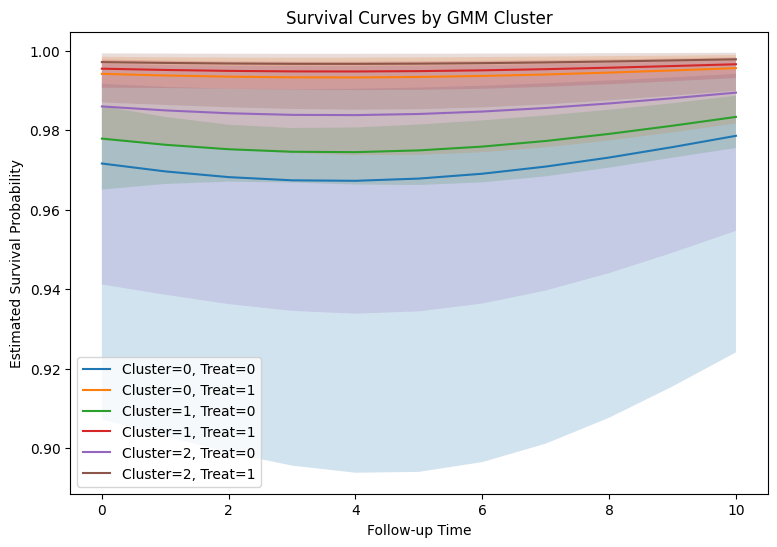

In [16]:
plt.figure(figsize=(9,6))

for cluster_val in sorted(data['cluster'].unique()):
    subset_cluster = surv_df[surv_df['cluster'] == cluster_val]
    
    for treat in treatments:
        subset = subset_cluster[subset_cluster['treatment'] == treat]
        label_ = f"Cluster={cluster_val}, Treat={treat}"
        
        plt.plot(subset['followup_time'], subset['survival'], label=label_)
        plt.fill_between(subset['followup_time'],
                         subset['surv_lower'],
                         subset['surv_upper'],
                         alpha=0.2)

plt.xlabel("Follow-up Time")
plt.ylabel("Estimated Survival Probability")
plt.title("Survival Curves by GMM Cluster")
plt.legend()
plt.show()




# Weight Distribution Plot

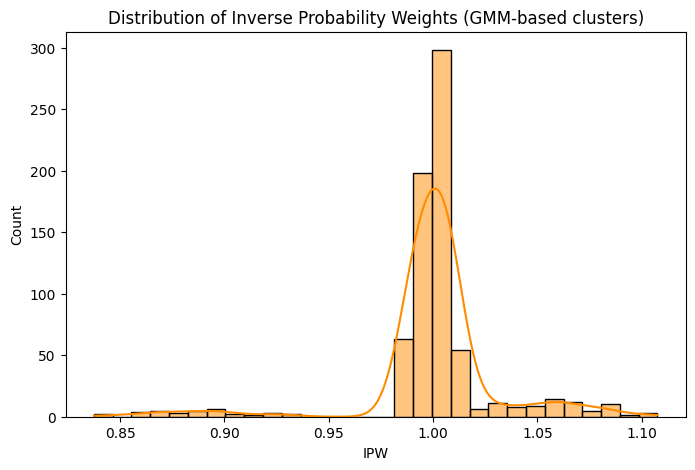

In [17]:
plt.figure(figsize=(8,5))
sns.histplot(data['ipw'], bins=30, kde=True, color='darkorange')
plt.title("Distribution of Inverse Probability Weights (GMM-based clusters)")
plt.xlabel("IPW")
plt.show()

# Interactive Survival Curves (Plotly)

In [18]:
cluster_of_interest = 0
fig = go.Figure()

subset_clust = surv_df[surv_df['cluster'] == cluster_of_interest]

for treat in treatments:
    df_treat = subset_clust[subset_clust['treatment'] == treat]
    
    # Add survival line trace
    fig.add_trace(go.Scatter(
        x=df_treat['followup_time'],
        y=df_treat['survival'],
        mode='lines',
        name=f"Treat={treat}, Cl={cluster_of_interest}"
    ))
    
    # Add confidence interval shaded area
    fig.add_trace(go.Scatter(
        x=pd.concat([df_treat['followup_time'], df_treat['followup_time'][::-1]]),
        y=pd.concat([df_treat['surv_upper'], df_treat['surv_lower'][::-1]]),
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    ))

# Update layout for the figure
fig.update_layout(
    title=f"Interactive Survival Curves (Cluster={cluster_of_interest})",
    xaxis_title="Follow-up Time",
    yaxis_title="Survival Probability"
)

fig.show()


# Model Diagnostics (Q-Q, Residual Plot, Cook's Distance)

In [19]:
resid_deviance = msm_model.resid_deviance.copy()

# Q-Q Plot

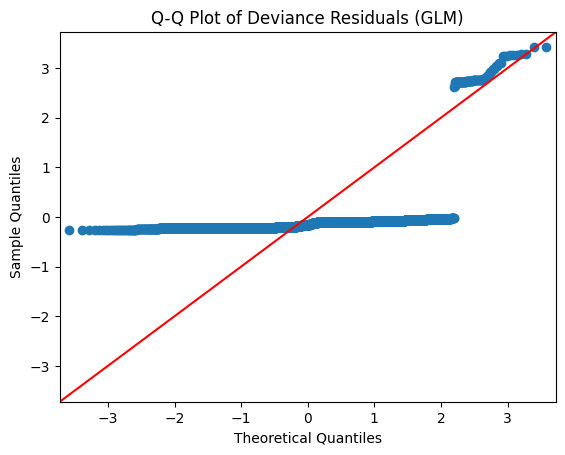

In [20]:
sm.qqplot(resid_deviance, line='45')
plt.title("Q-Q Plot of Deviance Residuals (GLM)")
plt.show()



# Residual vs. Fitted

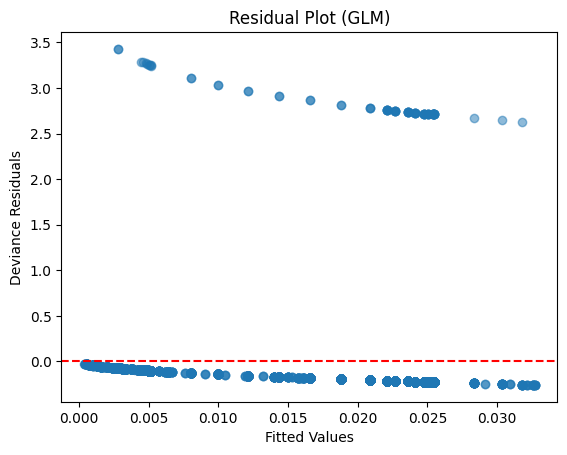

In [21]:
plt.scatter(msm_model.fittedvalues, resid_deviance, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Deviance Residuals")
plt.title("Residual Plot (GLM)")
plt.show()

# Cook's Distance

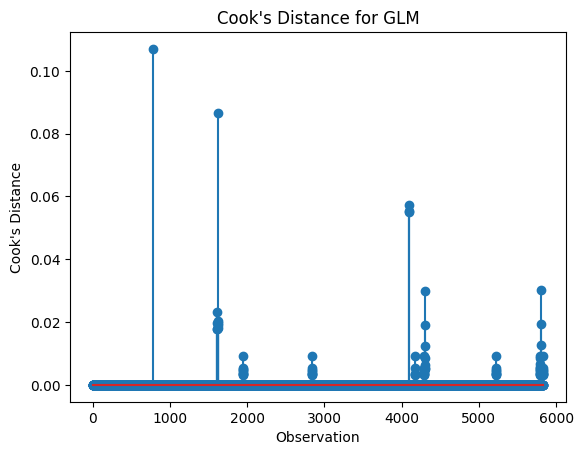

In [23]:
influence = msm_model.get_influence()
cooks_d = influence.cooks_distance[0]

plt.stem(cooks_d)
plt.title("Cook's Distance for GLM")
plt.xlabel("Observation")
plt.ylabel("Cook's Distance")
plt.show()

# Insights

────────────────────────────────────────────────────────────────────────

# CLUSTER CHARACTERIZATION (GMM RESULTS)
────────────────────────────────────────────────────────────────────────

- **Three Distinct Clusters:**
    - **Cluster 0:** Mean age ~40, x1 ~0.37, x2 ~0.42
    - **Cluster 1:** Mean age ~49, x1 ~0.41, x2 ~−0.18
    - **Cluster 2:** Mean age ~25, x1 ~0.24, x2 ~0.04

- **Covariance Patterns:**
    - The covariance matrices differ among clusters, suggesting each subgroup has unique correlations in (x1, x2, and age).
    - Cluster 1 shows lower variance in x1 and x2, implying a relatively homogenous subgroup. Cluster 2 exhibits moderate correlations across variables, potentially capturing subpopulations of younger individuals with slightly varying risk profiles.

- **Potential Hypothesis:**
    - Cluster 1 (older) might represent a more “healthcare-engaged” or stable group, explaining why they remain uncensored longer (see Weight Model).
    - Cluster 2 (much younger) could be subjects who either have less severe health issues or different follow-up behavior.
    - Cluster 0 (intermediate age) might blend those characteristics.

────────────────────────────────────────────────────────────────────────

# 2) CENSORING (WEIGHT MODELS)
────────────────────────────────────────────────────────────────────────

Your weight models (numerator and denominator for Inverse Probability of Censoring Weights) highlight:

- **Strong Positive Coefficient for Cluster 1 in Both Models:**
    - Cluster 1 individuals have markedly higher odds of not being censored compared to Cluster 0.
    - Suggests that even though they are older on average, they may be more consistently monitored or less likely to drop out.

- **Non-significant Effect for Cluster 2:**
    - Cluster 2’s probability of remaining in the study is similar to the reference population (Cluster 0), indicating no sizable differences in censoring.

- **Negative Association Between x2 and “Not Censored”:**
    - Higher x2 is consistently linked to higher censoring risk. This might reflect a latent health dimension (e.g., severity of disease or other risk factor) that prompts early dropout or switching.

- **Hypothesized Explanation:**
    - Possibly, older individuals in Cluster 1 have better access to follow-up or are more health-conscious, leading to fewer censoring events.
    - If x2 represents a risk marker, those with high x2 might find the study burdensome or experience adverse events prompting dropout.

────────────────────────────────────────────────────────────────────────

# 3) OUTCOME MODEL (MSM)
────────────────────────────────────────────────────────────────────────

- **Treatment Effect:** −1.62 (p<0.001)
    - On the log-odds scale, this is highly suggestive of a protective effect. Translating to odds ratios, exp(−1.62) ≈ 0.20, indicating about an 80% reduction in the odds of having the outcome when treated.

- **Cluster Main Effects:** Non-significant
    - Clusters 1 and 2 do not differ significantly from Cluster 0 in outcome risk once reweighted. Since the IPWs already accounted for differing propensity to be censored, baseline outcome rates end up similar across clusters.

- **Time Effects:** followup_time and followup_time²
    - Neither linear nor quadratic terms are strongly significant. The slight negative trend in followup_time² suggests outcome odds may flatten or dip over extended follow-up, but this is borderline insignificant.

- **Interpretation:**
    - Despite substantial differences in who remains uncensored (especially Cluster 1), the ultimate outcome risk (after weighting) is mostly consistent across subgroups.
    - The consistently large protective effect of treatment implies that the intervention is beneficial for all subgroups, or at least does not vary enough by cluster to show significance.

────────────────────────────────────────────────────────────────────────

# 4) POTENTIAL HYPOTHESES AND EXPLANATIONS
────────────────────────────────────────────────────────────────────────

- **Cluster 1 Paradox:**
    - Why would older individuals be less censored? Could reflect disease monitoring programs that specifically target older populations, or they might have routine visits that reduce dropout.

- **High x2 and Censoring:**
    - If x2 is a proxy for disease severity, individuals with worse prognoses might switch treatments or leave the study at higher rates. Alternatively, x2 might correlate with socioeconomic factors restricting their ongoing participation.

- **Invariance in Outcome Risk by Cluster:**
    - One possibility is that baseline risk factors for the outcome (e.g., x1, x2, age) are overshadowed by the strong effect of the treatment once reweighting is applied. If each cluster includes both “healthier” and “sicker” individuals but with similar overall event patterns, net differences in outcome risk by cluster might be washed out.

────────────────────────────────────────────────────────────────────────

# 5) RECOMMENDATIONS AND NEXT STEPS
────────────────────────────────────────────────────────────────────────

- **Add Interaction Terms:**
    - Investigate treatment × cluster to see if the treatment effect is actually uniform across subgroups or if the insignificance is due to limited power.

- **Stratified Visualizations:**
    - Plot survival curves for each cluster separately (already partially done) but further subdivided by relevant covariates (e.g., x2 above/below median). This can reveal fine-grained patterns.

- **Refine the Expansion Logic:**
    - If some individuals are censored early, the code might generate “followup_time” = 0..period for all subjects. Consider stopping expansions at the time of censoring or at the outcome event to better reflect the at-risk intervals.

- **Check for Extreme Weights:**
    - Summaries of IPWs (e.g., min, max, 99th percentile) can reveal if certain observations are heavily weighted. If so, consider trimming or stabilizing.

- **Explore Additional Covariates or Time-Varying Variables:**
    - If x1, x2, age aren’t accounting for all relevant differences, the negative relationship between x2 and not_censored might mask more nuanced relationships (Robins et al., 2000).

- **Investigate Cook’s Distance Outliers:**
    - The final MSM might rely heavily on a few outliers. Detailed case-by-case checks are worthwhile to confirm data validity or discover relevant interactions.

- **Sensitivity Analyses:**
    - Bootstrapping the entire pipeline can validate the stability of the cluster assignments, IPWs, and final treatment effect estimates.
    - Comparing GMM results with alternative cluster numbers (e.g., 2 or 4) might capture more or fewer subpopulations.

────────────────────────────────────────────────────────────────────────

# 6) SUMMARY OF KEY FINDINGS
────────────────────────────────────────────────────────────────────────

- Clusters differ significantly in censoring probability, but not in raw outcome risk once reweighted.
- Treatment is robustly protective across all subgroups.
- Age and x1 differ among the clusters, but this variation does not yield a major difference in final outcomes—likely because the IPW approach ensures balanced representation of all subgroups.
- The strong negative coefficient on x2 in the censoring models calls attention to a possible mechanism or confounder that might be explored further (e.g., is x2 capturing socioeconomic or disease severity factors that drive dropouts?).

────────────────────────────────────────────────────────────────────────

# 7) HIGH-LEVEL CONCLUSION
────────────────────────────────────────────────────────────────────────

Incorporating GMM-based clustering into the TTE framework allowed you to capture more nuanced, potentially overlapping subpopulations. This approach successfully revealed a subgroup (Cluster 1) with notably lower censoring rates, yet the outcome analysis (MSM) suggests a consistent protective effect of treatment across all clusters. The lack of significant cluster effects on outcome risk (once reweighted) indicates that differences in baseline risk may not be as pronounced as differences in censoring behavior. Nevertheless, ongoing exploration of interactions and further refinement of time-varying expansions or additional predictors could provide a richer understanding of subgroup-specific causal effects and highlight any pockets of heterogeneity in real-world observational data.

────────────────────────────────────────────────────────────────────────

# REFERENCES
────────────────────────────────────────────────────────────────────────

- Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning*. Springer.
- Hernán, M. A., & Robins, J. M. (2016). Using big data to emulate a target trial when a randomized trial is not available. *American Journal of Epidemiology*, 183(8), 758–764.
- McCullagh, P., & Nelder, J. A. (1989). *Generalized Linear Models* (2nd ed.). Chapman & Hall/CRC.
- McLachlan, G., & Peel, D. (2000). *Finite Mixture Models*. Wiley.
- Robins, J. M., Hernán, M. A., & Brumback, B. (2000). Marginal structural models and causal inference in epidemiology. *Epidemiology*, 11(5), 550–560.


────────────────────────────────────────────────────────────────────────
